# This is data mining code for the HAP780 final project after exporting the datasets from All of Us

## Import data

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Load the datasets
df_analysis = pd.read_csv('./data/df_analysis_extended.csv')

In [3]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Columns: 13088 entries, race_Asian to no_food_Never true 68-77
dtypes: bool(17), float64(13051), int64(20)
memory usage: 161.7 MB


## Use SAFE (Sequentially Adjusted Forecasts using Exogeneity) method to rule out predictors

In [4]:
# Define the target variable
target = 'No_remission'

# Set X and y variables
X = df_analysis.drop(columns=[target])
y = df_analysis[target]

In [5]:
# Calculate the correlation between each predictor and the target variable
correlations = df_analysis.corr()[target]

print(correlations)

race_Asian                        0.005282
race_Black or African American    0.027433
race_None Indicated               0.007869
race_White                       -0.023343
ethnicity_Hispanic or Latino     -0.004433
                                    ...   
no_food_Never true 28-37         -0.000487
no_food_Never true 38-47         -0.022518
no_food_Never true 48-57         -0.036608
no_food_Never true 58-67         -0.001226
no_food_Never true 68-77          0.027168
Name: No_remission, Length: 13088, dtype: float64


In [6]:
# Remove correlation between and target and target
correlations = correlations.drop("No_remission", axis=0)

In [7]:
print(f"min corr: {correlations.min()}")
print(f"max corr: {correlations.max()}")

min corr: -0.08576630230282557
max corr: 0.2547803417767349


In [8]:
# Define correlation threshold
correlation_threshold_neg = -0.06 # remove very low correlations (bottom 70%)
correlation_threshold_pos = 0.175 # remove very low correlations (bottom 70%)

# Rule out predictors based on the correlation threshold
predictors_to_rule_out = []
for predictor in correlations.index:
    if correlations[predictor] > 0 and correlations[predictor] < correlation_threshold_pos:
        predictors_to_rule_out.append(predictor)
    elif correlations[predictor] < 0 and correlations[predictor] > correlation_threshold_neg:
        predictors_to_rule_out.append(predictor)
    elif correlations[predictor] == 0:
        predictors_to_rule_out.append(predictor)

# Remove the ruled out predictors from the data
df_analysis_reduced = df_analysis.drop(predictors_to_rule_out, axis=1).copy()

df_analysis_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Data columns (total 66 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   dx_34713006                                                      1621 non-null   float64
 1   dx_49084001                                                      1621 non-null   float64
 2   dx_76069003                                                      1621 non-null   float64
 3   dx_193570009                                                     1621 non-null   float64
 4   dx_266435005                                                     1621 non-null   float64
 5   dx_400096001                                                     1621 non-null   float64
 6   income_Annual Income: 150k 200k                                  1621 non-null   bool   
 7   No_remission                              

In [9]:
# Calculate the variances for remaining variables
variances = df_analysis_reduced.drop(columns=[target]).var()

print(f"min var: {variances.min()}")
print(f"max var: {variances.max()}")

min var: 0.020547444421596173
max var: 0.20093906367811362


In [10]:
# Define variance threshold
variance_threshold = 0.02 # remove low variance (10% of max)

# Rule out predictors based on the variance threshold
predictors_to_rule_out = []
for predictor in df_analysis_reduced.columns:
    if df_analysis_reduced[predictor].var() < variance_threshold:
        predictors_to_rule_out.append(predictor)

# Remove the ruled out predictors from the data
df_analysis_reduced = df_analysis_reduced.drop(predictors_to_rule_out, axis=1)

df_analysis_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Data columns (total 66 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   dx_34713006                                                      1621 non-null   float64
 1   dx_49084001                                                      1621 non-null   float64
 2   dx_76069003                                                      1621 non-null   float64
 3   dx_193570009                                                     1621 non-null   float64
 4   dx_266435005                                                     1621 non-null   float64
 5   dx_400096001                                                     1621 non-null   float64
 6   income_Annual Income: 150k 200k                                  1621 non-null   bool   
 7   No_remission                              

## Train Test Split

In [11]:
# Import library
from sklearn.model_selection import train_test_split

# Splitting the data into training and test sets
train_set, test_set = train_test_split(df_analysis, test_size=0.20, random_state=42)

In [12]:
# Write train and test sets to a file for reference
train_set.to_csv("./data/train.csv", index=False)
test_set.to_csv("./data/test.csv", index=False)

## Set outcome and independent variables

In [13]:
# Splitting the data into features and target
X_train = train_set.drop(columns=['No_remission'])
y_train = train_set['No_remission']


# Splitting the test data into features and target
X_test = test_set.drop(columns=['No_remission'])
y_test = test_set['No_remission']

## Feature Selection LASSO with Cross-Validation (5-fold)

In [14]:
# Minimize warning
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Import library
from sklearn.linear_model import LassoCV

# columns to keep for LASSO
cols_to_keep = df_analysis_reduced.drop(columns=['No_remission']).columns.to_list()

# Initializing LassoCV (5 folds)
lasso_cv = LassoCV(cv=5, random_state=42)

# Fitting the model
lasso_cv.fit(X_train[cols_to_keep], y_train)

# Print the minimum lambda value selected by LassoCV
print("\nMinimum lambda (selected alpha):", lasso_cv.alpha_)

# Print the intercept
print("Intercept:", lasso_cv.intercept_)

# Get the feature coefficients
coef = pd.Series(lasso_cv.coef_, index=cols_to_keep)

# Filter out the features which have a abs(coef) < 0.01
selected_features_lasso = coef[abs(coef) != 0].index.tolist()

# Print selected feature and direction
print(f"Number of features selected: {len(selected_features_lasso)}\n")

for feature, coef in zip(selected_features_lasso, lasso_cv.coef_):
    print(f"feature: '{feature}' | coefficient: {round(coef,2)}")


Minimum lambda (selected alpha): 0.002079947812518876
Intercept: 0.16815699052821084
Number of features selected: 31

feature: 'dx_34713006' | coefficient: 0.0
feature: 'dx_49084001' | coefficient: -0.08
feature: 'dx_266435005' | coefficient: 0.0
feature: 'race_White dx_40733004' | coefficient: 0.0
feature: 'race_White dx_400096001' | coefficient: 0.01
feature: 'ethnicity_Not Hispanic or Latino dx_34713006' | coefficient: 0.0
feature: 'ethnicity_Not Hispanic or Latino dx_266435005' | coefficient: -0.0
feature: 'ethnicity_Not Hispanic or Latino dx_400096001' | coefficient: -0.17
feature: 'dx_34713006 dx_193570009' | coefficient: -0.0
feature: 'dx_34713006 insurance_Health Insurance: Yes' | coefficient: 0.0
feature: 'dx_35489007 dx_266435005' | coefficient: 0.19
feature: 'dx_36923009 dx_59621000' | coefficient: 0.04
feature: 'dx_40930008 dx_54398005' | coefficient: 0.0
feature: 'dx_40930008 dx_193570009' | coefficient: 0.02
feature: 'dx_49084001 dx_79604008' | coefficient: 0.0
feature: 

In [15]:
# Filter train and test sets for selected features
X_train_selected_lasso = X_train[selected_features_lasso]
X_test_selected_lasso = X_test[selected_features_lasso]

In [16]:
# Calculate McFadden's R-squared
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression


# Get predicted probabilities
log_reg = LogisticRegression()
log_reg.fit(X_train_selected_lasso, y_train)

y_pred = log_reg.predict(X_test_selected_lasso)

# Calculate log-likelihood of the model
log_likelihood_model = -log_loss(y_test, y_pred)

# Calculate log-likelihood of the null model
null_model_probs = np.full_like(y_pred, y_test.mean())
log_likelihood_null_model = -log_loss(y_test, null_model_probs)

# Calculate McFadden's R-squared
mcfadden_r2 = 1 - (log_likelihood_model / log_likelihood_null_model)

print("\nMcFadden's R-squared:", mcfadden_r2)


McFadden's R-squared: 0.12871287128712883


## Model training

In [17]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             matthews_corrcoef, 
                             roc_auc_score, 
                             average_precision_score)

In [18]:
# Import library
from sklearn.model_selection import GridSearchCV

In [19]:
# Logistic Regression

# Define training sets as unbalanced with feature selection (X_train_selected_lasso, y_train)
# Define test set as balanced with feature selection (X_test_selected_lasso, y_test)

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Initialize the GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), 
                              param_grid=param_grid_lr, 
                              scoring='roc_auc',
                              cv=5)

# Fit the grid search to the data
grid_search_lr.fit(X_train_selected_lasso, y_train)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_lr.best_params_)

# Predict
best_estimator = grid_search_lr.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
unbal_logreg = best_estimator

Best parameters set found on training set:
{'C': 1, 'penalty': 'l1'}
Confusion Matrix: [[207  17]
 [ 71  30]]
Precision: 0.6382978723404256
Recall: 0.297029702970297
F-Measure: 0.40540540540540543
MCC: 0.29098759820812875
ROC Area: 0.7328279702970298
PRC Area: 0.5747803614898944


In [20]:
# Random Forest

# Define training sets as unbalanced with feature selection (X_train_selected_lasso, y_train)
# Define test set as balanced with feature selection (X_test_selected_lasso, y_test)

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                              param_grid=param_grid_rf, 
                              scoring='roc_auc',
                              cv=5)

# Fit the grid search to the data
grid_search_rf.fit(X_train_selected_lasso, y_train)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_rf.best_params_)

# Predict
best_estimator = grid_search_rf.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
unbal_rf = best_estimator

Best parameters set found on training set:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Confusion Matrix: [[207  17]
 [ 71  30]]
Precision: 0.6382978723404256
Recall: 0.297029702970297
F-Measure: 0.40540540540540543
MCC: 0.29098759820812875
ROC Area: 0.7249602192362095
PRC Area: 0.5683435277892714


In [21]:
# Naive Bayes

# Define training sets as unbalanced with feature selection (X_train_selected_lasso, y_train)
# Define test set as balanced with feature selection (X_test_selected_lasso, y_test)

# Define the parameter grid for GaussianNB
param_grid_gnb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Initialize the GridSearchCV object for GaussianNB
grid_search_gnb = GridSearchCV(estimator=GaussianNB(), 
                               param_grid=param_grid_gnb, 
                               scoring='roc_auc', 
                               cv=5)

# Fit the grid search to the data
grid_search_gnb.fit(X_train_selected_lasso, y_train)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_gnb.best_params_)

# Predict
best_estimator = grid_search_gnb.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
unbal_nb = best_estimator

Best parameters set found on training set:
{'var_smoothing': 0.012328467394420659}
Confusion Matrix: [[185  39]
 [ 52  49]]
Precision: 0.5568181818181818
Recall: 0.48514851485148514
F-Measure: 0.5185185185185186
MCC: 0.3239569831083884
ROC Area: 0.7451158062234795
PRC Area: 0.5893772272051505


In [22]:
# XGBoost

# Define training sets as unbalanced with feature selection (X_train_selected_lasso, y_train)
# Define test set as balanced with feature selection (X_test_selected_lasso, y_test)

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.7, 1]
}

# Initialize the GridSearchCV object for XGBoost
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                               param_grid=param_grid_xgb, 
                               scoring='roc_auc', 
                               cv=5)

# Fit the grid search to the data
grid_search_xgb.fit(X_train_selected_lasso, y_train)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_xgb.best_params_)

# Predict
best_estimator = grid_search_xgb.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
unbal_xgb = best_estimator

Best parameters set found on training set:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
Confusion Matrix: [[207  17]
 [ 68  33]]
Precision: 0.66
Recall: 0.32673267326732675
F-Measure: 0.43708609271523186
MCC: 0.3217583459686212
ROC Area: 0.7373364568599717
PRC Area: 0.582835265271969


## Plotting the ROC curves using specificity and recall

In [23]:
# Import the libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

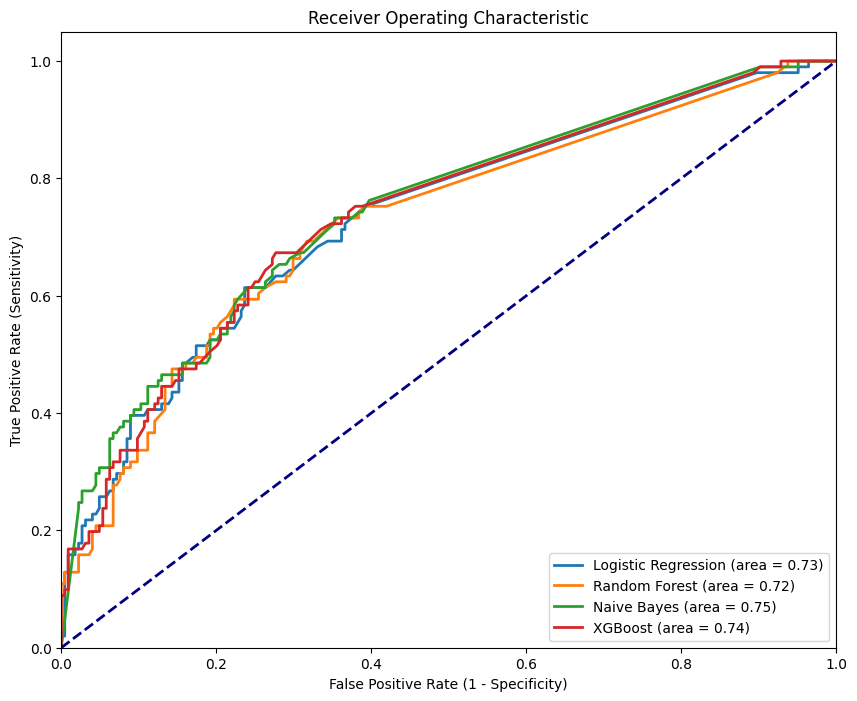

In [24]:
# Define models
models = {
    'Logistic Regression': unbal_logreg,
    'Random Forest': unbal_rf,
    'Naive Bayes': unbal_nb,
    'XGBoost': unbal_xgb,
}

plt.figure(figsize=(10, 8))

# Calculate ROC curve and ROC AUC for each model
for name, model in models.items():
    probas_ = model.predict_proba(X_test_selected_lasso)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


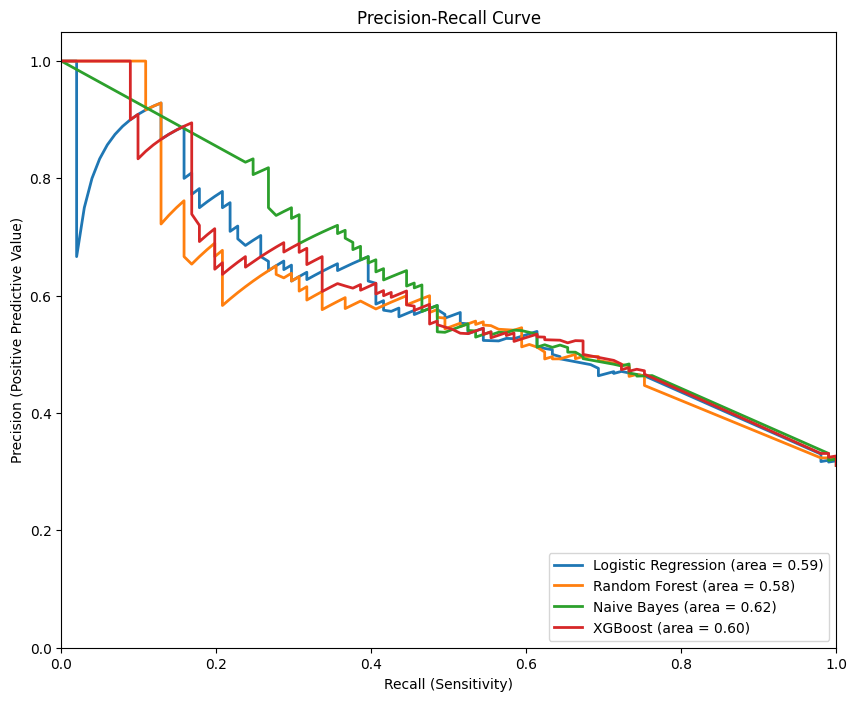

In [25]:
from sklearn.metrics import precision_recall_curve, auc


plt.figure(figsize=(10, 8))

# Calculate precision-recall curve and AUC for each model
for name, model in models.items():
    probas_ = model.predict_proba(X_test_selected_lasso)
    precision, recall, thresholds = precision_recall_curve(y_test, probas_[:, 1])
    auprc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (area = {auprc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right") 
plt.show()

## Race Mix and Ethnicity Mix Analysis

In [26]:
# Filter test set for particular race or ethnicity

# Non-Hispanic White
test_set_NHWhite = test_set[(test_set['race_White'] == 1) & (test_set['ethnicity_Not Hispanic or Latino'] == 1)]
X_test_NHWhite = test_set_NHWhite.drop(columns=['No_remission'])
X_test_NHWhite = X_test_NHWhite[selected_features_lasso]
y_test_NHWhite = test_set_NHWhite['No_remission']

# Non-Hispanic Black
test_set_NHBlack = test_set[(test_set['race_Black or African American'] == 1) & (test_set['ethnicity_Not Hispanic or Latino'] == 1)]
X_test_NHBlack = test_set_NHBlack.drop(columns=['No_remission'])
X_test_NHBlack = X_test_NHBlack[selected_features_lasso]
y_test_NHBlack = test_set_NHBlack['No_remission']

# Hispanic
test_set_Hispanic = test_set[test_set['ethnicity_Hispanic or Latino'] == 1]
X_test_Hispanic = test_set_Hispanic.drop(columns=['No_remission'])
X_test_Hispanic = X_test_Hispanic[selected_features_lasso]
y_test_Hispanic = test_set_Hispanic['No_remission']

# Other
test_set_Other = test_set[~(((test_set['race_White'] == 1) & (test_set['ethnicity_Not Hispanic or Latino'] == 1)) | 
                            ((test_set['race_Black or African American'] == 1) & (test_set['ethnicity_Not Hispanic or Latino'] == 1)) | 
                            (test_set['ethnicity_Hispanic or Latino'] == 1))]
X_test_Other = test_set_Other.drop(columns=['No_remission'])
X_test_Other = X_test_Other[selected_features_lasso]
y_test_Other = test_set_Other['No_remission']

# Number of selected rows
print(f"""Non-Hispanic White: {test_set_NHWhite.shape[0]} | 
      Non-Hispanic Black: {test_set_NHBlack.shape[0]} | 
      Hispanic: {test_set_Hispanic.shape[0]} | 
      Other: {test_set_Other.shape[0]}""")

Non-Hispanic White: 224 | 
      Non-Hispanic Black: 40 | 
      Hispanic: 38 | 
      Other: 23


In [27]:
# Test models on Non-Hispanic White test set

# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb
}

# Metrics collection
results = {}

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test_NHWhite)
    
    # Metrics
    confusion = confusion_matrix(y_test_NHWhite, y_pred)
    precision = precision_score(y_test_NHWhite, y_pred)
    recall = recall_score(y_test_NHWhite, y_pred)
    fmeasure = f1_score(y_test_NHWhite, y_pred)
    mcc = matthews_corrcoef(y_test_NHWhite, y_pred)
    roc_area = roc_auc_score(y_test_NHWhite, model.predict_proba(X_test_NHWhite)[:, 1])
    prc_area = average_precision_score(y_test_NHWhite, model.predict_proba(X_test_NHWhite)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression (Unbalanced)
Confusion Matrix: [[141  13]
 [ 45  25]]
Precision: 0.6578947368421053
Recall: 0.35714285714285715
F-Measure: 0.46296296296296297
MCC: 0.3368136467373198
ROC Area: 0.7794990723562153
PRC Area: 0.6191655072836463


Model: Random Forest (Unbalanced)
Confusion Matrix: [[140  14]
 [ 45  25]]
Precision: 0.6410256410256411
Recall: 0.35714285714285715
F-Measure: 0.45871559633027525
MCC: 0.3254275739747723
ROC Area: 0.7810760667903526
PRC Area: 0.6173954956408798


Model: Naive Bayes (Unbalanced)
Confusion Matrix: [[125  29]
 [ 29  41]]
Precision: 0.5857142857142857
Recall: 0.5857142857142857
F-Measure: 0.5857142857142857
MCC: 0.3974025974025974
ROC Area: 0.788821892393321
PRC Area: 0.6249562762000526


Model: XGBoost (Unbalanced)
Confusion Matrix: [[141  13]
 [ 42  28]]
Precision: 0.6829268292682927
Recall: 0.4
F-Measure: 0.5045045045045045
MCC: 0.37827483945859247
ROC Area: 0.7930426716141002
PRC Area: 0.6342808460973306




In [28]:
# Test models on Non-Hispanic Black test set

# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb
}

# Metrics collection
results = {}

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test_NHBlack)
    
    # Metrics
    confusion = confusion_matrix(y_test_NHBlack, y_pred)
    precision = precision_score(y_test_NHBlack, y_pred)
    recall = recall_score(y_test_NHBlack, y_pred)
    fmeasure = f1_score(y_test_NHBlack, y_pred)
    mcc = matthews_corrcoef(y_test_NHBlack, y_pred)
    roc_area = roc_auc_score(y_test_NHBlack, model.predict_proba(X_test_NHBlack)[:, 1])
    prc_area = average_precision_score(y_test_NHBlack, model.predict_proba(X_test_NHBlack)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression (Unbalanced)
Confusion Matrix: [[25  3]
 [10  2]]
Precision: 0.4
Recall: 0.16666666666666666
F-Measure: 0.23529411764705882
MCC: 0.08247860988423225
ROC Area: 0.5535714285714285
PRC Area: 0.40349150441062204


Model: Random Forest (Unbalanced)
Confusion Matrix: [[26  2]
 [10  2]]
Precision: 0.5
Recall: 0.16666666666666666
F-Measure: 0.25
MCC: 0.14547859349066158
ROC Area: 0.5029761904761905
PRC Area: 0.43148529711029704


Model: Naive Bayes (Unbalanced)
Confusion Matrix: [[22  6]
 [ 9  3]]
Precision: 0.3333333333333333
Recall: 0.25
F-Measure: 0.28571428571428575
MCC: 0.03919309008348103
ROC Area: 0.5863095238095238
PRC Area: 0.4671474358974359


Model: XGBoost (Unbalanced)
Confusion Matrix: [[24  4]
 [10  2]]
Precision: 0.3333333333333333
Recall: 0.16666666666666666
F-Measure: 0.2222222222222222
MCC: 0.030556616567607043
ROC Area: 0.5029761904761905
PRC Area: 0.376975089968511




In [29]:
# Test models on Hispanic test set

# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb
}

# Metrics collection
results = {}

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test_Hispanic)
    
    # Metrics
    confusion = confusion_matrix(y_test_Hispanic, y_pred)
    precision = precision_score(y_test_Hispanic, y_pred)
    recall = recall_score(y_test_Hispanic, y_pred)
    fmeasure = f1_score(y_test_Hispanic, y_pred)
    mcc = matthews_corrcoef(y_test_Hispanic, y_pred)
    roc_area = roc_auc_score(y_test_Hispanic, model.predict_proba(X_test_Hispanic)[:, 1])
    prc_area = average_precision_score(y_test_Hispanic, model.predict_proba(X_test_Hispanic)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression (Unbalanced)
Confusion Matrix: [[24  1]
 [10  3]]
Precision: 0.75
Recall: 0.23076923076923078
F-Measure: 0.3529411764705882
MCC: 0.29490392637578633
ROC Area: 0.6784615384615384
PRC Area: 0.605387667887668


Model: Random Forest (Unbalanced)
Confusion Matrix: [[25  0]
 [10  3]]
Precision: 1.0
Recall: 0.23076923076923078
F-Measure: 0.375
MCC: 0.40599897147057507
ROC Area: 0.6323076923076923
PRC Area: 0.5757042882042882


Model: Naive Bayes (Unbalanced)
Confusion Matrix: [[23  2]
 [ 9  4]]
Precision: 0.6666666666666666
Recall: 0.3076923076923077
F-Measure: 0.42105263157894735
MCC: 0.2962370845394112
ROC Area: 0.6846153846153846
PRC Area: 0.6170575528041591


Model: XGBoost (Unbalanced)
Confusion Matrix: [[25  0]
 [10  3]]
Precision: 1.0
Recall: 0.23076923076923078
F-Measure: 0.375
MCC: 0.40599897147057507
ROC Area: 0.6538461538461539
PRC Area: 0.5879273504273503




In [30]:
# Test models on "Other" test set

# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb
}

# Metrics collection
results = {}

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test_Other)
    
    # Metrics
    confusion = confusion_matrix(y_test_Other, y_pred)
    precision = precision_score(y_test_Other, y_pred)
    recall = recall_score(y_test_Other, y_pred)
    fmeasure = f1_score(y_test_Other, y_pred)
    mcc = matthews_corrcoef(y_test_Other, y_pred)
    roc_area = roc_auc_score(y_test_Other, model.predict_proba(X_test_Other)[:, 1])
    prc_area = average_precision_score(y_test_Other, model.predict_proba(X_test_Other)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression (Unbalanced)
Confusion Matrix: [[17  0]
 [ 6  0]]
Precision: 0.0
Recall: 0.0
F-Measure: 0.0
MCC: 0.0
ROC Area: 0.6470588235294117
PRC Area: 0.39171842650103517


Model: Random Forest (Unbalanced)
Confusion Matrix: [[16  1]
 [ 6  0]]
Precision: 0.0
Recall: 0.0
F-Measure: 0.0
MCC: -0.12666009927622474
ROC Area: 0.6372549019607843
PRC Area: 0.36394064872325743


Model: Naive Bayes (Unbalanced)
Confusion Matrix: [[15  2]
 [ 5  1]]
Precision: 0.3333333333333333
Recall: 0.16666666666666666
F-Measure: 0.2222222222222222
MCC: 0.0639137490706142
ROC Area: 0.6568627450980392
PRC Area: 0.47505175983436854


Model: XGBoost (Unbalanced)
Confusion Matrix: [[17  0]
 [ 6  0]]
Precision: 0.0
Recall: 0.0
F-Measure: 0.0
MCC: 0.0
ROC Area: 0.6372549019607843
PRC Area: 0.3546813894639982




c:\Users\vladc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vladc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Display coefficients for logistic regression

In [31]:
# Display intercept
print("Intercept:", unbal_logreg.intercept_)

# Display feature names and coefficients
feature_names = X_train_selected_lasso.columns
coefficients = unbal_logreg.coef_[0]

print("\nFeature coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.2f}")

Intercept: [-1.63225929]

Feature coefficients:
dx_34713006: 0.00
dx_49084001: -0.62
dx_266435005: 0.00
race_White dx_40733004: -1.84
race_White dx_400096001: 1.01
ethnicity_Not Hispanic or Latino dx_34713006: 0.29
ethnicity_Not Hispanic or Latino dx_266435005: 0.09
ethnicity_Not Hispanic or Latino dx_400096001: 0.03
dx_34713006 dx_193570009: 0.89
dx_34713006 insurance_Health Insurance: Yes: 0.02
dx_35489007 dx_266435005: 0.51
dx_36923009 dx_59621000: 0.55
dx_40930008 dx_54398005: 0.37
dx_40930008 dx_193570009: 1.09
dx_49084001 dx_79604008: -0.71
dx_55822004 dx_76069003: -0.18
dx_64859006 dx_76069003: -0.35
dx_65846009 dx_76069003: 1.04
dx_68496003 dx_240134003: 1.57
dx_70153002 dx_76069003: 0.64
dx_76069003 dx_189336000: 0.76
dx_76069003 dx_235595009: -0.25
dx_76069003 dx_703938007: 0.34
dx_76069003 insurance_Health Insurance: Yes: 0.51
dx_79604008 dx_123756000: -1.16
dx_193570009 no_food_Never true: 0.08
dx_239873007 dx_266435005: 0.26
dx_266435005 dx_414916001: 0.13
dx_266435005 tob

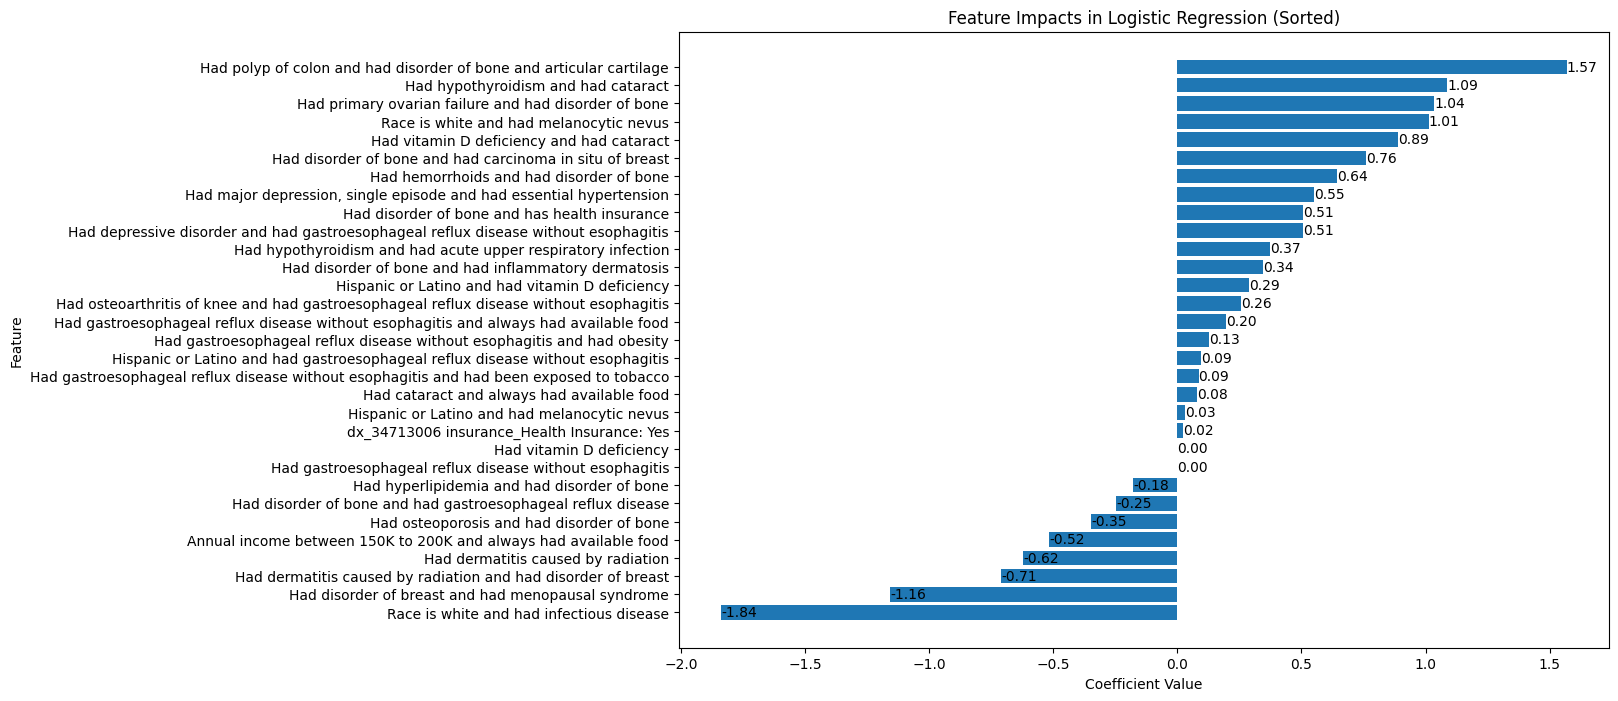

In [32]:
# Create a sorted list of (coefficient, feature) tuples
sorted_features = sorted(zip(coefficients, feature_names), reverse=True)

# Separate the coefficients and feature names
sorted_coefs, sorted_feature_names = zip(*sorted_features)

# Create a dictionary to map old feature names to new feature names
feature_mapping = {
    'dx_34713006' : 'Had vitamin D deficiency',
    'dx_49084001' : 'Had dermatitis caused by radiation',
    'dx_266435005' : 'Had gastroesophageal reflux disease without esophagitis',
    'race_White dx_40733004': 'Race is white and had infectious disease',
    'race_White dx_400096001' : 'Race is white and had melanocytic nevus',
    'ethnicity_Not Hispanic or Latino dx_34713006' : 'Hispanic or Latino and had vitamin D deficiency',
    'ethnicity_Not Hispanic or Latino dx_266435005' : 'Hispanic or Latino and had gastroesophageal reflux disease without esophagitis',
    'ethnicity_Not Hispanic or Latino dx_400096001' : 'Hispanic or Latino and had melanocytic nevus',
    'dx_34713006 dx_193570009' : 'Had vitamin D deficiency and had cataract',
    'dx_34713006 insurance_Health Insurance : Yes' : 'Had vitamin D deficiency and has health insurace',
    'dx_35489007 dx_266435005' : 'Had depressive disorder and had gastroesophageal reflux disease without esophagitis',
    'dx_36923009 dx_59621000' : 'Had major depression, single episode and had essential hypertension',
    'dx_40930008 dx_54398005' : 'Had hypothyroidism and had acute upper respiratory infection',
    'dx_40930008 dx_193570009' : 'Had hypothyroidism and had cataract',
    'dx_49084001 dx_79604008' : 'Had dermatitis caused by radiation and had disorder of breast',
    'dx_55822004 dx_76069003' : 'Had hyperlipidemia and had disorder of bone',
    'dx_64859006 dx_76069003' : 'Had osteoporosis and had disorder of bone',
    'dx_65846009 dx_76069003' : 'Had primary ovarian failure and had disorder of bone',
    'dx_68496003 dx_240134003' : 'Had polyp of colon and had disorder of bone and articular cartilage',
    'dx_70153002 dx_76069003' : 'Had hemorrhoids and had disorder of bone',
    'dx_76069003 dx_189336000' : 'Had disorder of bone and had carcinoma in situ of breast',
    'dx_76069003 dx_235595009' : 'Had disorder of bone and had gastroesophageal reflux disease',
    'dx_76069003 dx_703938007' : 'Had disorder of bone and had inflammatory dermatosis',
    'dx_76069003 insurance_Health Insurance: Yes' : 'Had disorder of bone and has health insurance',
    'dx_79604008 dx_123756000' : 'Had disorder of breast and had menopausal syndrome',
    'dx_193570009 no_food_Never true' : 'Had cataract and always had available food',
    'dx_239873007 dx_266435005' : 'Had osteoarthritis of knee and had gastroesophageal reflux disease without esophagitis',
    'dx_266435005 dx_414916001' : 'Had gastroesophageal reflux disease without esophagitis and had obesity',
    'dx_266435005 tobacco_ever' : 'Had gastroesophageal reflux disease without esophagitis and had been exposed to tobacco',
    'dx_266435005 no_food_Never true' : 'Had gastroesophageal reflux disease without esophagitis and always had available food',
    'income_Annual Income: 150k 200k no_food_Never true' : 'Annual income between 150K to 200K and always had available food'

}

# Replace old feature names with new feature names
sorted_feature_names = [feature_mapping.get(feature, feature) for feature in sorted_feature_names]

# Create a bar plot
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(sorted_feature_names)), sorted_coefs)
plt.yticks(np.arange(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Impacts in Logistic Regression (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to show the largest coefficients at the top

# Add coefficient values at the end of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{sorted_coefs[i]:.2f}', ha='left', va='center')

plt.show()